# Application de l'apprentissage profond aux séries temporelles

In [714]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Le jeu de données de données utilisé provient du site [Open Data Réseaux Energies](https://odre.opendatasoft.com/explore/dataset/consommation-quotidienne-brute/table/?sort=date_heure&dataChart=eyJxdWVyaWVzIjpbeyJjaGFydHMiOlt7InR5cGUiOiJsaW5lIiwiZnVuYyI6IlNVTSIsInlBeGlzIjoiY29uc29tbWF0aW9uX2JydXRlX2dhel9ncnRnYXoiLCJzY2llbnRpZmljRGlzcGxheSI6dHJ1ZSwiY29sb3IiOiIjNjZjMmE1In0seyJ0eXBlIjoibGluZSIsImZ1bmMiOiJTVU0iLCJ5QXhpcyI6ImNvbnNvbW1hdGlvbl9icnV0ZV9nYXpfdGVyZWdhIiwic2NpZW50aWZpY0Rpc3BsYXkiOnRydWUsImNvbG9yIjoiIzhkYTBjYiJ9LHsidHlwZSI6ImxpbmUiLCJmdW5jIjoiU1VNIiwieUF4aXMiOiJjb25zb21tYXRpb25fYnJ1dGVfZWxlY3RyaWNpdGVfcnRlIiwic2NpZW50aWZpY0Rpc3BsYXkiOnRydWUsImNvbG9yIjoiI2ZjOGQ2MiJ9XSwieEF4aXMiOiJkYXRlX2hldXJlIiwibWF4cG9pbnRzIjpudWxsLCJ0aW1lc2NhbGUiOiJkYXkiLCJzb3J0IjoiIiwiY29uZmlnIjp7ImRhdGFzZXQiOiJjb25zb21tYXRpb24tcXVvdGlkaWVubmUtYnJ1dGUiLCJvcHRpb25zIjp7InNvcnQiOiItZGF0ZV9oZXVyZSJ9fX1dLCJ0aW1lc2NhbGUiOiIiLCJzaW5nbGVBeGlzIjpmYWxzZSwiZGlzcGxheUxlZ2VuZCI6dHJ1ZSwiYWxpZ25Nb250aCI6dHJ1ZX0%3D). Il contient des relevés par heure ou par demi-heure de la consommation brute de gaz et d'électricité en France métropolitaine entre 2012 et 2023.

Pour ce travail, nous nous contenterons de travailler sur la consommation d'électricité (exprimée en MWh) en ramenant les données à une fréquence journalière. 

## Nettoyage et préparation des données brutes

In [715]:
# Importation du dataset et sélection des colonnes nécessaires
cons_elec = pd.read_csv("C:/Users/timot/Documents/Data/TimeSeries/consommation-quotidienne-brute.csv", 
                   sep=';', 
                   usecols=['date', 'heure', 'consommation_brute_totale'])

# Suppression des lignes où la consommation horaire n'est pas indiquée
cons_elec = cons_elec[cons_elec.consommation_brute_totale.notna()]

cons_elec

,date,heure,consommation_brute_totale
27792,31/05/2022,23:00,75231.0
27794,31/05/2022,22:00,73850.0
27796,31/05/2022,21:00,75994.0
27798,31/05/2022,20:00,79614.0
27800,31/05/2022,19:00,80458.0
...,...,...,...
210374,01/01/2012,04:00,106242.0
210376,01/01/2012,03:00,108544.0
210378,01/01/2012,02:00,110996.0
210380,01/01/2012,01:00,111674.0


Cette première étape a permis de se débarasser des colonnes inutiles et de supprimer les lignes consacrées aux relevés par demi-heure ou trop récentes. 

La seconde consiste à regrouper les données par date puis de faire la somme des 24 mesures pour chacune de ces dates.

In [716]:
# Création de colonnes séparées pour le jour, le mois et l'année
cons_elec[['jour', 'mois', 'annee']] = cons_elec.date.str.split(pat='/', expand=True)

# Regroupement et somme des valeurs de chaque groupe
cons_elec = cons_elec.groupby(by=['annee', 'mois', 'jour']).sum()

# Note : on aurait pu se contenter de grouper par la colonne 'date' 
# mais nous voulions garder la possibilité de switcher vers des une série mensualisée

cons_elec

consommation_brute_totale
annee mois jour                           
2012  01   01                    2684351.0
           02                    3245494.0
           03                    3631647.0
           04                    3629618.0
           05                    3698721.0
...                                    ...
2022  05   27                    1522262.0
           28                    1450891.0
           29                    1451424.0
           30                    1785507.0
           31                    1814252.0

[3804 rows x 1 columns]

On peut à présent visualiser la série sur laquelle nous allons travailler et qui s'étend du 01/01/2012 au 31/05/2022.

On remarque au passage qu'elle suit une saisonnalité annuelle et ne montre pas de _trend_ évident à la baisse ou à la hausse.

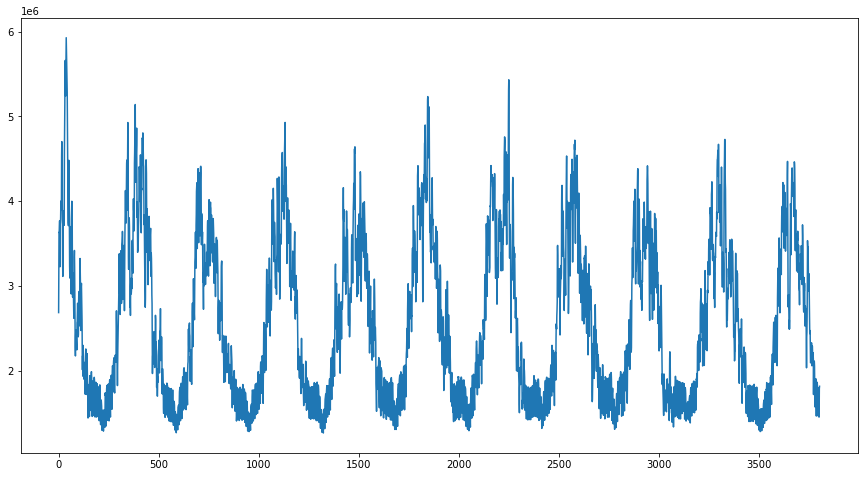

In [717]:
cons_elec = cons_elec.values
plt.figure(figsize=(15,8))
plt.plot(cons_elec)
plt.show()

## Prétraitement des données pour le RNN

Comme de coutume, on normalise les données pour faciliter l'ajustement du réseau avant de les séparer en ensembles de test (20%) et d'apprentissage (80%)

In [718]:
# Normalisation
cons_elec_norm = (cons_elec - np.mean(cons_elec)) / np.std(cons_elec)

# Séparation entraînement / test
cut = int(0.8*len(cons_elec_norm))
train_data = cons_elec_norm[:cut]
test_data = cons_elec_norm[cut:]

__Notre problème consiste à prévoir, pour une date $t$, la consommation électrique du jour suivant en se basant sur la consommation des 10 jours précédents.__

Pour le traiter, on crée une fonction qui va découper notre série en séquences de _lookback_ valeurs successives, chacune associée à une valeur cible correspondant à la mesure située _horizon_ jours après la dernière valeur de la séquence. Les séquences sont stockées en lignes dans une matrice qui sera fournie en entrée du réseau.

In [719]:
def prep_sequences(data, horizon, lookback):
    
    # On crée un array d'indices parcourant la longueur de la série avec un pas correspondant au lookback
    # Ces indices correspondent à ceux des premières valeurs après chaque séquence
    indices = np.arange(lookback, len(data), lookback)
    
    # On s'assure de ne pas créer de séquence dont la valeur cible se situerait en dehors des données
    if (indices+horizon-1)[-1] >= len(data):
        indices = indices[:-1]
        
    # Extraction des valeurs cibles
    y = data[indices + horizon - 1]
    
    # Récupération des séquences correspondantes
    x = data[:indices[-1]].reshape(len(indices), lookback, 1)
    return x, y

In [720]:
horizon = 1
lookback = 10
x_train, y_train = prep_sequences(train_data, horizon, lookback)
x_test, y_test = prep_sequences(test_data, horizon, lookback)

## Application d'un réseau à couche récurrente au problème de prévision

In [738]:
from keras import Sequential
from keras.layers import GRU, Dense
from keras.optimizers import RMSprop
from keras.callbacks import ModelCheckpoint
from keras.models import load_model

from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error

Les réseaux à couche récurrente sont particulièrement adaptés au traitement des données séquentielles, comme des fichiers de texte ou en l'occurrence des séries temporelles. 

Dans sa version de base, un RNN contient une unique couche cachée qui traite les éléments d'une séquence un à un, calcule un output à partir de l'élément courant puis le réinjecte dans le calcul de l'output suivant : de cette manière, le réseau peut capter l'information contenue dans la succession des éléments, comme une tendance à la hausse pour une série temporelle par exemple.

En pratique, les RNN simples sont peu utilisés pour des tâches de deep learning : on leur préfère généralement des variantes plus élaborées comme les LSTM (_Long-Short Term Memory_) ou les GRU (_Gated Reccurent Unit_) qui ont l'avantage de mieux intégrer le contexte lointain, en plus de l'information contenue dans le voisinage immédiat.

Nous utiliserons ici des couches GRU qui sont moins puissantes mais plus simples et moins gourmandes que les LSTM en termes de calculs.

In [722]:
model = Sequential()
# On définit une première unité GRU à 8 connexions
# Les arguments dropout servent à prévenir le risque de surapprentissage
# On conserve la tangente hyperbolique comme fonction d'activation par défaut
model.add(GRU(8, dropout=0.1, recurrent_dropout=0.5, return_sequences=True))
model.add(GRU(12, dropout=0.1, recurrent_dropout=0.5))
model.add(Dense(1))

model.compile(loss='mae', 
              optimizer=RMSprop(learning_rate=0.005))

In [723]:
evolution = model.fit(x_train, y_train, 
                      batch_size=8,
                      epochs=120,
                      shuffle=True,
                      # On isole 30% des données train pour la validation (contrôler le surajustement)
                      validation_split=0.3, 
                      verbose=None,
                      # On sauvegarde le modèle ayant obtenu le meilleur score de validation au cours de l'entraînement
                      callbacks=ModelCheckpoint('rnn_cons_elec.h5', 
                                                save_best_only=True,
                                                monitor='val_loss')
                     )

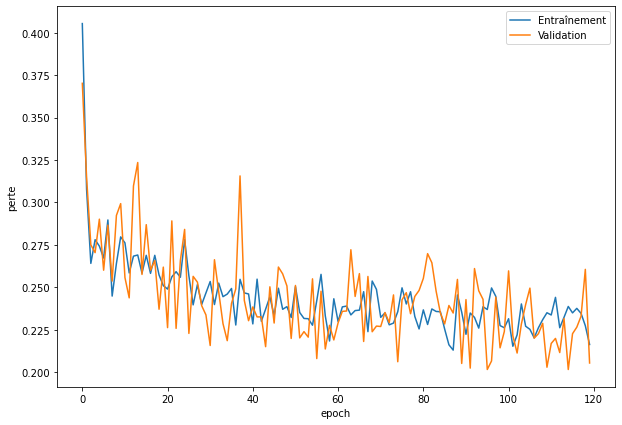

Minima obtenus sur la fonction de perte : 0.213 (train) / 0.202 (validation)


In [730]:
plt.figure(figsize=(10,7))
plt.plot(evolution.history['loss'], label='Entraînement')
plt.plot(evolution.history['val_loss'], label='Validation')
plt.ylabel('perte')
plt.xlabel('epoch')
plt.legend()
plt.show()

min_train = round(np.min(evolution.history['loss']), 3)
min_val = round(np.min(evolution.history['val_loss']), 3)
print(f'Minima obtenus sur la fonction de perte : {min_train} (train) / {min_val} (validation)')

Malgré la volatilité de la _validation loss_ due au faible nombre de données, on constate que la fonction de perte diminue dans des proportions similaires pour l'ensemble d'apprentissage comme pour l'ensemble de validation au cours de l'ajustement : __il ne semble pas y avoir de problème de suraprentissage__.

On remarque également qu'à son plus bas, la fonction de perte (erreur moyenne absolue) tourne autour de 0.2 ~ 0.21. Le meilleur modèle enregistré appliqué à l'ensemble de test donne quant à lui une MAE de 0.207.

En "dénormalisant" ce résultat, on montre ci-dessous que __nos prévisions sont en moyenne éloignées de 192 600 MWh des valeurs réelles et que cette erreur correspond en moyenne à 1.183% de ces valeurs réelles sur l'ensemble de test__.

In [740]:
# Chargement du meilleur modèle
best = load_model('rnn_cons_elec.h5')
# Prévisions sur x_train
train_prev = best.predict(x_train, verbose=None)
# Prévisions sur x_test
test_prev = best.predict(x_test, verbose=None)

In [754]:
mape_test = round(mean_absolute_percentage_error(y_test, test_prev), 3)
mae_test = mean_absolute_error(y_test, test_prev)
print(f"MAPE sur l'ensemble de test : {mape_test}%\nMAE \"dénormalisée\" : {round(np.std(cons_elec)*mae_test, 3)}")

MAPE sur l'ensemble de test : 1.183%
MAE "dénormalisée" : 192575.567


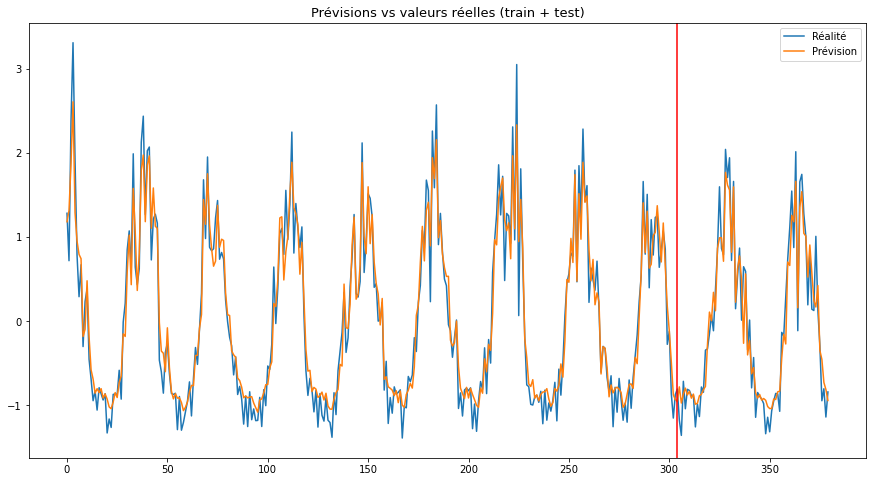

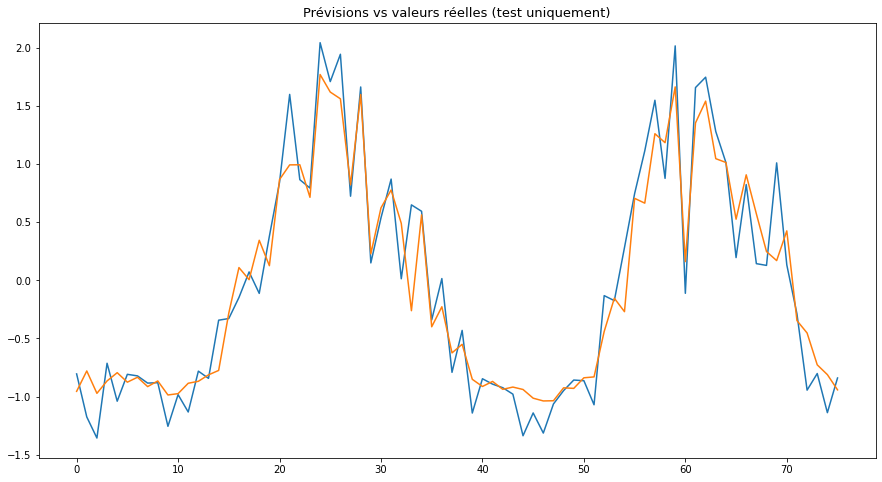

In [737]:
reel = np.append(y_train, y_test)
prev = np.append(train_prev, test_prev)

plt.figure(figsize=(15,8))
plt.plot(reel, label='Réalité')
plt.plot(prev, label='Prévision')
plt.axvline(len(y_train), color='red')
plt.legend()
plt.title("Prévisions vs valeurs réelles (train + test)", size=13)
plt.show()

plt.figure(figsize=(15,8))
plt.plot(y_test)
plt.plot(test_prev)
plt.title("Prévisions vs valeurs réelles (test uniquement)", size=13)
plt.show()

Ces deux graphiques montrent que notre modèle, quoique modeste, est globalement capable de prévoir l'évolution de la consommation journalière d'électricité. 

De nombreuses améliorations pourraient cependant être apportées comme l'augmentation du nombre de séquences utilisées pour l'apprentissage et la validation.